In [1]:
## Import libraries

In [2]:
from eventstore.oltp import EventContext
from eventstore.sql import EventSession
from eventstore.common import ConfigurationReader
from pyspark.sql import SparkSession

ConfigurationReader.setEventUser("admin")
ConfigurationReader.setEventPassword("password")

In [3]:
#sparkSession = SparkSession.builder.config('spark.jars', './spark-time-series-sql.jar').appName("EventStore SQL in Python").getOrCreate()
sparkSession = SparkSession.builder.appName("EventStore SQL in Python").getOrCreate()
eventSession = EventSession(sparkSession.sparkContext, "EVENTDB")
eventSession.set_query_read_option("SnapshotNow")
eventSession._jvm.org.apache.spark.sql.types.SqlTimeSeries.register(eventSession._jsparkSession)
eventSession.open_database()
ctx = EventContext.get_event_context("EVENTDB")

In [4]:
from eventstore.catalog import TableSchema
from pyspark.sql.types import *

In [5]:
table_names = ctx.get_names_of_tables()
for idx, name in enumerate(table_names):
    print(idx, name)

In [6]:
from datetime import datetime

def datetime_converter(datetime_string):
    # (1) Convert to datetime format
    utc_time = datetime.strptime(datetime_string.split('.000Z')[0], "%Y-%m-%dT%H:%M:%S")

    return int((utc_time - datetime(1970, 1, 1)).total_seconds())

In [7]:
## create table and loading data for DHT

In [8]:
# Define table schema to be created
with EventContext.get_event_context("EVENTDB") as ctx:
    schema = StructType([
        StructField("sensor_id", IntegerType(), nullable = False),
        StructField("timestamp", IntegerType(), nullable = False),
        StructField("location", IntegerType(), nullable = False),
        StructField("humidity", FloatType(), nullable = True)
    ])  
    table_schema = TableSchema("dht_table", schema,
                                sharding_columns=["sensor_id"],
                                pk_columns=["sensor_id","timestamp","location"])

In [9]:
# try create table if not exist
# try:
#     ctx.drop_table("DHT_TABLE")
# except Exception as error:
#     print(error)
try:
    ctx.create_table(table_schema)
except Exception as error:
    print(error)
    
table_names = ctx.get_names_of_tables()
for idx, name in enumerate(table_names):
    print(name)

ADMIN.DHT_TABLE


In [10]:
dht_table = eventSession.load_event_table("dht_table")

In [11]:
# ingest data into table
import os
resolved_table_schema = ctx.get_table("dht_table")
print(resolved_table_schema)
with open(os.environ['DSX_PROJECT_DIR']+'/datasets/dht_1k.csv') as f:
    f.readline()
    content = f.readlines()
content = [l.split(",") for l in content]
batch = [dict(sensor_id=int(c[5]), timestamp=datetime_converter(c[7]), location=int(c[0]), humidity=float(c[2])) for c in content]
ctx.batch_insert(resolved_table_schema, batch)

ResolvedTableSchema(tableName=ADMINDHT_TABLE, schema=StructType(List(StructField(SENSOR_ID,IntegerType,false),StructField(TIMESTAMP,IntegerType,false),StructField(LOCATION,IntegerType,false),StructField(HUMIDITY,FloatType,true))), sharding_columns=['SENSOR_ID'], pk_columns=['SENSOR_ID', 'TIMESTAMP', 'LOCATION'], partition_columns=None, schema_name=Some(ADMIN))


In [12]:
# verify ingested result
dht_table = eventSession.load_event_table("dht_table")
dht_table.count()

41569

In [13]:
dht_table.createOrReplaceTempView("dht_raw_table")

In [14]:
eventSession.sql("select count(*) from dht_raw_table").show()

+--------+
|count(1)|
+--------+
|   41569|
+--------+



In [15]:
## create table and loading data for SDS

In [16]:
with EventContext.get_event_context("EVENTDB") as ctx:
    schema = StructType([
        StructField("sensor_id", IntegerType(), nullable = False),
        StructField("timestamp", LongType(), nullable = False),
        StructField("location", IntegerType(), nullable = False),
        StructField("p_1", DoubleType(), nullable = True)
    ])  
    table_schema = TableSchema("sds_table", schema,
                                sharding_columns=["sensor_id"],
                                pk_columns=["sensor_id","timestamp","location"])


In [17]:
# try:
#     ctx.drop_table("SDS_TABLE")
# except Exception as error:
#     print(error)
try:
    ctx.create_table(table_schema)
except Exception as error:
    print(error)
table_names = ctx.get_names_of_tables()
for idx, name in enumerate(table_names):
    print(name)

ADMIN.DHT_TABLE
ADMIN.SDS_TABLE


In [18]:
sds_table = eventSession.load_event_table("sds_table")

In [19]:
with EventContext.get_event_context("EVENTDB") as ctx:
    resolved_table_schema = ctx.get_table("sds_table")
    with open(os.environ['DSX_PROJECT_DIR']+'/datasets/sds_1k.csv') as f:
        f.readline()
        content = f.readlines()
    content = [l.split(",") for l in content]
    batch = [dict(sensor_id=int(c[5]), timestamp=datetime_converter(c[7]), location=int(c[0]), p_1=float(c[2])) for c in content if c[2] != ""]
    ctx.batch_insert(resolved_table_schema, batch)

In [20]:
sds_table=eventSession.load_event_table("sds_table")
sds_table.count()

51246

In [21]:
sds_table.createOrReplaceTempView("sds_raw_table")

In [22]:
eventSession.sql("select * from sds_raw_table").show(5)

+---------+----------+--------+----+
|SENSOR_ID| TIMESTAMP|LOCATION| P_1|
+---------+----------+--------+----+
|     1108|1504137694|     541| 7.1|
|     1108|1504137843|     541| 7.0|
|     1108|1504137992|     541|7.95|
|     1108|1504138140|     541| 8.4|
|     1108|1504138288|     541|7.37|
+---------+----------+--------+----+
only showing top 5 rows



In [23]:
## Query

In [24]:
sql="SELECT count(*) FROM dht_raw_table"
eventSession.sql(sql).show(5)

+--------+
|count(1)|
+--------+
|   41569|
+--------+



# Perform a temporal full align of sds and dht time series

This query has a few main things to consider:

## Creating your time series

first a time series must be created

### sds time series

```sql
SELECT location, D_TIME_SERIES(timestamp, p_1) AS sds FROM sds_raw_table GROUP BY location
```

### dht time series

```sql
SELECT location, D_TIME_SERIES(timestamp, humidity) AS dht FROM dht_raw_table GROUP BY location
```

## Performing full temporal align

Performing a full temporal align requires 2 parameters:

- The left Time Series
- The right Time Series

Once given, the returned output will be 2 columns (the 2 aligned time series) as **left_column**_aligned and **right_column**_aligned

*Note: With this method, all missing values will be replaced with null*

In [25]:
sql="SELECT location, TIME_SERIES(timestamp, humidity) AS dht FROM dht_raw_table GROUP BY location"
eventSession.sql(sql).show(5)
eventSession.sql(sql).count()

+--------+--------------------+
|location|                 dht|
+--------+--------------------+
|    2662|[(1503834699,37.9...|
|    2683|[(1503961904,87.0...|
|    2682|[(1503960327,67.6...|
|    2680|[(1503959071,86.5...|
|    2684|[(1503963045,89.9...|
+--------+--------------------+
only showing top 5 rows



27

In [26]:
sql="SELECT location, TIME_SERIES(timestamp, p_1) AS sds FROM sds_raw_table GROUP BY location"
eventSession.sql(sql).show(5)
eventSession.sql(sql).count()

+--------+--------------------+
|location|                 sds|
+--------+--------------------+
|    2662|[(1503834699,5.33...|
|    2683|[(1503961757,4.8)...|
|    2682|[(1503960326,8.87...|
|    2680|[(1503958922,30.8...|
|    2684|[(1503963045,38.3...|
+--------+--------------------+
only showing top 5 rows



33

In [27]:
stmt = """
    SELECT sds_table.location, TS_FULL_ALIGN(dht, sds, TS_INTERPOLATOR_NEAREST(-1.0)) FROM 
        (SELECT location, TIME_SERIES(timestamp, humidity) AS dht FROM dht_raw_table GROUP BY location) AS dht_table
        INNER JOIN
        (SELECT location, TIME_SERIES(timestamp, p_1) AS sds FROM sds_raw_table GROUP BY location) AS sds_table
        ON dht_table.location = sds_table.location
"""
df = eventSession.sql(stmt)
df.show()
df.count()
eventSession.sql(stmt).createOrReplaceTempView("dht_sds_ts_table")

+--------+--------------------+--------------------+
|location|         dht_aligned|         sds_aligned|
+--------+--------------------+--------------------+
|    2662|[(1503834699,37.9...|[(1503834699,5.33...|
|    2683|[(1503961757,-1.0...|[(1503961757,4.8)...|
|    2682|[(1503960326,-1.0...|[(1503960326,8.87...|
|    2680|[(1503958922,-1.0...|[(1503958922,30.8...|
|    2684|[(1503963045,89.9...|[(1503963045,38.3...|
|    1773|[(1501703936,-1.0...|[(1501703936,424....|
|    2633|[(1503575337,-1.0...|[(1503575337,6.2)...|
|    1323|[(1503897678,-1.0...|[(1503897678,6.27...|
|    2686|[(1503964139,64.4...|[(1503964139,7.0)...|
|    2681|[(1503960072,-1.0...|[(1503960072,24.2...|
|     966|[(1501545689,99.9...|[(1501545689,7.83...|
|    2640|[(1503609572,64.4...|[(1503609572,3.0)...|
|     732|[(1501545688,73.5...|[(1501545688,0.3)...|
|    2652|[(1503702364,67.9...|[(1503702364,9.1)...|
|    1314|[(1501577454,53.5...|[(1501577454,5.43...|
|     462|[(1501545650,87.1...|[(1501545650,4.

# Display the aligned TimeSeries table

In [28]:
eventSession.sql("select count(*) from dht_sds_ts_table").show()

+--------+
|count(1)|
+--------+
|      23|
+--------+



# Fill nulls with a the nearest value


In [29]:
eventSession.sql("SELECT location, TS_FILLNA(dht_aligned,TS_INTERPOLATOR_NEAREST(-1.0)) as ts FROM dht_sds_ts_table").createOrReplaceTempView("dht_no_nulls")
eventSession.sql("SELECT location, TS_FILLNA(sds_aligned,TS_INTERPOLATOR_NEAREST(-1.0)) as ts FROM dht_sds_ts_table").createOrReplaceTempView("sds_no_nulls")

In [30]:
eventSession.sql("SELECT location, TS_EXPLODE(ts) FROM dht_no_nulls").createOrReplaceTempView("dht_exploded")
eventSession.sql("SELECT location, TS_EXPLODE(ts) FROM sds_no_nulls").createOrReplaceTempView("sds_exploded")

In [31]:
eventSession.sql("select * from dht_exploded").count()

49786

In [32]:
eventSession.sql("select * from sds_exploded").count()

49786

In [33]:
stmt = """
    select dht_exploded.location, dht_exploded.ts_timeTick as timestamp, dht_exploded.ts_value as humidity, sds_exploded.ts_value as p_1 FROM
        dht_exploded
        INNER JOIN
        sds_exploded
        ON dht_exploded.location=sds_exploded.location and dht_exploded.ts_timeTick=sds_exploded.ts_timeTick
"""
df = eventSession.sql(stmt)
df.show()
df.count()

+--------+----------+------------------+-----+
|location| timestamp|          humidity|  p_1|
+--------+----------+------------------+-----+
|     138|1501548094|               1.0|  5.9|
|     138|1501564534|               1.0|  7.2|
|     138|1501583914|               1.0|  4.1|
|     138|1501604784|               1.0|  4.2|
|     138|1501606399|               1.0| 4.83|
|     138|1501610653|               1.0| 8.07|
|     138|1501636474|58.400001525878906| 5.63|
|     138|1501656427|               1.0|  4.1|
|     138|1501683577|               1.0|  7.9|
|     314|1504069209|56.400001525878906| 9.52|
|     314|1504105745| 53.20000076293945|  4.8|
|     314|1504109853|54.599998474121094| 5.05|
|     314|1504115575|58.099998474121094|10.38|
|     314|1504127465| 62.70000076293945|  8.5|
|     314|1504146568|  71.9000015258789|  4.9|
|     314|1504165064| 74.80000305175781| 3.95|
|     314|1504184729| 63.29999923706055| 1.58|
|     314|1504218776|  69.9000015258789| 3.08|
|     462|150

49786

# Describe a TimeSeries

TimeSeries SQL has the ability to describe a TimeSeries, which will give back statistics of the TimeSeries, each being in their own column.

In [34]:
eventSession.sql("SELECT location, TS_DESCRIBE(ts) FROM dht_no_nulls").toPandas()

,location,ts_time_min,ts_time_max,ts_time_mean,ts_mode,ts_unique,ts_frequency,ts_first_time_tick,ts_first_value,ts_last_time_tick,ts_last_value,ts_count,ts_num_mean,ts_num_std,ts_num_min,ts_num_max,ts_num_25,ts_num_50,ts_num_75
0,2662,1,14692,176.410194,34.500000,495,19,1503834699,37.900002,1504198104,50.700001,2061,50.948617,16.359299,27.299999,87.099998,36.500000,48.099998,63.099998
1,2683,1,46752,132.138105,87.699997,357,48,1503961757,-1.000000,1504223919,89.599998,1985,81.485290,12.982737,-1.000000,94.800003,80.300003,86.199997,89.300003
2,2682,1,528,116.768276,77.500000,471,22,1503960326,-1.000000,1504223872,80.900002,2258,66.481222,16.624317,-1.000000,92.800003,48.400002,71.400002,80.000000
3,2680,1,10955,100.226551,90.099998,573,30,1503958922,-1.000000,1504223921,92.800003,2645,64.734253,22.673204,-1.000000,92.900002,44.799999,69.199997,86.199997
4,2684,1,305,107.693768,90.000000,571,42,1503963045,89.900002,1504223987,93.000000,2424,69.974340,19.957587,23.900000,93.400002,56.225000,76.099998,86.500000
5,1773,1,336400,309.964008,55.500000,259,189,1501703936,-1.000000,1502461798,59.900002,2446,56.360057,8.133111,-1.000000,77.000000,49.500000,55.700001,63.400002
6,2633,1,223409,264.482714,50.000000,172,108,1503575337,-1.000000,1504195020,49.400002,2344,51.154138,3.781348,-1.000000,63.900002,49.400002,50.299999,51.599998
7,1323,1,121187,184.887179,99.900002,256,977,1503897678,-1.000000,1504186102,99.900002,1561,86.632736,21.704380,-1.000000,99.900002,72.700001,99.900002,99.900002
8,2686,1,341,108.548684,65.099998,337,54,1503964139,64.400002,1504223896,60.400002,2394,63.743024,8.151720,40.000000,87.000000,61.299999,64.800003,69.325003
9,2681,1,479,108.518092,90.199997,435,33,1503960072,-1.000000,1504223988,74.900002,2433,77.257337,12.447034,-1.000000,94.599998,70.900002,80.699997,87.400002


In [35]:
!wget --no-check-certificate http://daas.res.ibm.com/~mudhakar/timeseries_staging/time-series-assembly-1.0.0-jar-with-dependencies.jar -O ./time-series-assembly-1.0.0-jar-with-dependencies.jar
!wget --no-check-certificate http://daas.res.ibm.com/~mudhakar/timeseries_staging/sparktspy-0.0.0.0.tar.gz -O ./sparktspy-0.0.0.0.tar.gz
!wget --no-check-certificate http://daas.res.ibm.com/~mudhakar/timeseries_staging/tspy-0.0.0.0.tar.gz -O ./tspy-0.0.0.0.tar.gz
!wget --no-check-certificate http://daas.res.ibm.com/~mudhakar/timeseries/py4j-0.10.8.1.jar -O ./py4j-0.10.8.1.jar

--2019-07-26 02:48:11--  http://daas.res.ibm.com/~mudhakar/timeseries_staging/time-series-assembly-1.0.0-jar-with-dependencies.jar
Resolving daas.res.ibm.com (daas.res.ibm.com)... 173.192.226.22
Connecting to daas.res.ibm.com (daas.res.ibm.com)|173.192.226.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13506196 (13M) [application/x-java-archive]
Saving to: ‘./time-series-assembly-1.0.0-jar-with-dependencies.jar’

./time-series-assem 100%[=====================>]  12.88M  2.27MB/s   in 6.9s   

2019-07-26 02:48:18 (1.86 MB/s) - ‘./time-series-assembly-1.0.0-jar-with-dependencies.jar’ saved [13506196/13506196]

--2019-07-26 02:48:22--  http://daas.res.ibm.com/~mudhakar/timeseries_staging/sparktspy-0.0.0.0.tar.gz
Resolving daas.res.ibm.com (daas.res.ibm.com)... 173.192.226.22
Connecting to daas.res.ibm.com (daas.res.ibm.com)|173.192.226.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8797 (8.6K) [application/x-gzip]
Saving to: ‘./spa

In [36]:
!pip install -I tspy-0.0.0.0.tar.gz
!pip install -I sparktspy-0.0.0.0.tar.gz

Processing ./tspy-0.0.0.0.tar.gz
  Using cached https://files.pythonhosted.org/packages/3d/73/fe30c2daaaa0713420d0382b16fbb761409f532c56bdcc514bf7b6262bb6/pytz-2019.1-py2.py3-none-any.whl
  Stored in directory: /user-home/999/.cache/pip/wheels/ba/f3/cd/39efbcbaa0caed7b3790fb0b358f3a033d440a3e76f41df0a8
Successfully built tspy
sparkmagic 0.12.7 has requirement ipykernel<5,>=4.2.2, but you'll have ipykernel 5.1.0 which is incompatible.
You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Processing ./sparktspy-0.0.0.0.tar.gz
  Stored in directory: /user-home/999/.cache/pip/wheels/9e/5e/41/bfce6fd83dde0ada00a05965a18d856bebbced24ff268c4494
Successfully built sparktspy
You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [37]:
from tspy import TSContext
%env TMPDIR=/tmp/
%env TS_HOME=./time-series-assembly-1.0.0-jar-with-dependencies.jar
%env PY4J_PATH=./py4j-0.10.8.1.jar
tsc = TSContext(always_on_caching=True)
# tsc.stop()

env: TMPDIR=/tmp/
env: TS_HOME=./time-series-assembly-1.0.0-jar-with-dependencies.jar
env: PY4J_PATH=./py4j-0.10.8.1.jar


In [38]:
df = eventSession.sql("select * from sds_exploded").toPandas()

In [39]:
df.head()

,location,ts_timeTick,ts_value
0,2662,1503834699,5.33
1,2662,1503834845,4.53
2,2662,1503834846,4.53
3,2662,1503834992,4.00
4,2662,1503835139,4.73


In [40]:
mts = tsc.multi_time_series.df_observations(df, "location", "ts_timeTick", "ts_value")

## Get The Z-Normalized monthly average of each TimeSeries

In [41]:
import math
hourly_collected = mts.segment_series_by_time(3600, 3600) \
    .transform_series(tsc.math_reducers.average()) \
    .map_series_value(lambda x: 0.0 if math.isnan(x) else x) \
    .get_values(1501545600, 1504137600)
hourly_mts = tsc.multi_time_series.dict(hourly_collected)
zscore_mts = hourly_mts.transform_series(tsc.math_transforms.z_score()) 

In [42]:
# stmt = """
#     SELECT location,
#         TS_ZSCORE(
#             TS_SLICE(
#                 TS_FILLNA(
#                     TS_SEG_SUM(
#                         TS_SEGMENT_BY_TIME(ts, TS_HOURS(1), TS_HOURS(1))
#                     ), 
#                     TS_INTERPOLATOR_NEAREST()
#                 ),
#                 TS_DATE(2017,8,1),
#                 TS_DATE(2017,9,1)
#             ),
#             50.0,
#             .01
#         ) as z_norm_ts
#         FROM sds_no_nulls
# """
# eventSession.sql(stmt).createOrReplaceTempView("z_norm_table")
# eventSession.sql("select location, TS_EXPLODE(z_norm_ts) from z_norm_table").show()

In [43]:
# df = eventSession.sql("select location, TS_EXPLODE(z_norm_ts) from z_norm_table").toPandas()
# zscore_mts = tsc.multi_time_series.df_observations(df, "location", "z_norm_ts_timestamp", "z_norm_ts_value")

In [44]:
# zscore_mts.print()
print(zscore_mts.reduce_series(lambda x: x.count()))

{'2682': 721, '2681': 721, '2633': 721, '541': 721, '2684': 721, '1216': 721, '2408': 721, '462': 721, '2680': 721, '314': 721, '1773': 721, '1099': 721, '2686': 721, '2662': 721, '1314': 721, '966': 721, '2652': 721, '971': 721, '1323': 721, '2683': 721, '732': 721, '138': 721, '2640': 721}


## Perform KShape clustering on the z-normalized monthly average MultiTimeSeries

In [45]:
from tspy.ml.clustering import KShape

k_clusters = 3
num_runs = 30

model = KShape.run(zscore_mts, k_clusters, num_runs)

## Display Representative clusters

In [46]:
print({k: model.score(observations) for k, observations in zscore_mts.collect_as_map().items()})

{'2682': 2, '2681': 0, '1216': 2, '541': 0, '2684': 0, '2633': 2, '2408': 0, '462': 0, '2680': 0, '314': 2, '1773': 2, '1099': 0, '2686': 0, '2662': 0, '1314': 2, '966': 0, '2652': 0, '971': 2, '1323': 2, '2683': 0, '732': 0, '138': 0, '2640': 0}


In [47]:
import pixiedust

Pixiedust database opened successfully


In [48]:
centroids_mts = tsc.multi_time_series.dict(model.centroids)
centroids_df = centroids_mts.to_df_instants()


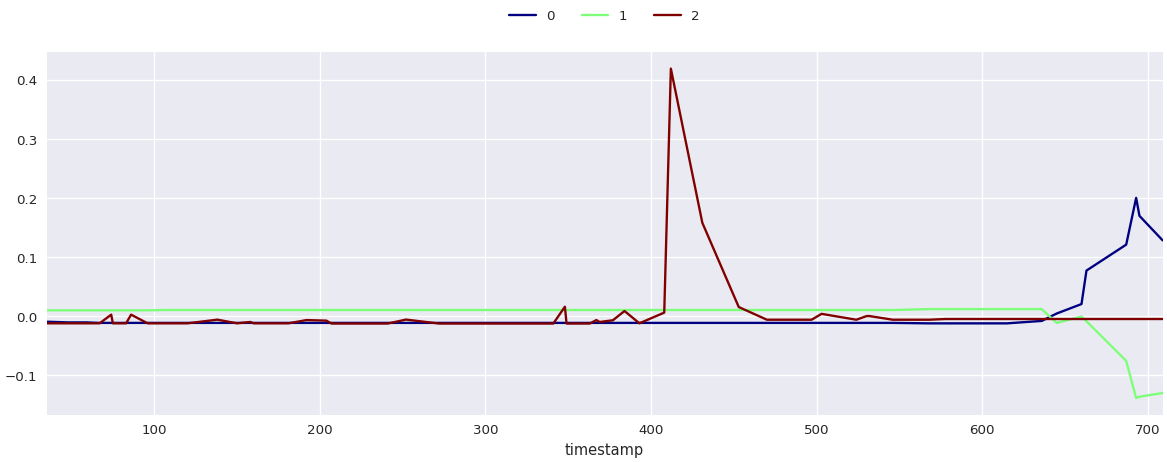

In [49]:
display(centroids_df)

In [50]:
centroids_df.head()

,timestamp,0,1,2
0,0,-0.009352,0.008399,-0.011995
1,1,-0.009352,0.008399,-0.003908
2,2,-0.009352,0.008399,-0.011995
3,3,-0.009352,0.008399,-0.011995
4,4,-0.009352,0.010015,-0.011995


In [51]:
import time

stmt = "SELECT TIME_SERIES(timestamp, humidity) AS dht FROM dht_raw_table"

df = eventSession.sql(stmt)
df.cache()
df.createOrReplaceTempView("table_a")
start = time.time()
df.show()
end = time.time()

+--------------------+
|                 dht|
+--------------------+
|[(1501545650,87.1...|
+--------------------+



In [52]:
total_time = end - start
print("ingestion time: " + str(total_time) + " seconds")

ingestion time: 699.7081711292267 seconds


In [53]:
stmt = "SELECT TS_RESAMPLE(dht, 3600, TS_INTERPOLATOR_NEAREST(0.0)) as dht_interp from table_a"
start = time.time()
eventSession.sql(stmt).show()
end = time.time()

+--------------------+
|          dht_interp|
+--------------------+
|[(1501545600,0.0)...|
+--------------------+



In [54]:
total_time = end - start
print("ingestion time: " + str(total_time) + " seconds")

ingestion time: 3.079747200012207 seconds


In [55]:
stmt = "select count(*) from (SELECT TS_EXPLODE(dht) from table_a)"
start = time.time()
eventSession.sql(stmt).show()
end = time.time()

+--------+
|count(1)|
+--------+
|   41569|
+--------+



In [56]:
total_time = end - start
print("ingestion time: " + str(total_time) + " seconds")

ingestion time: 0.6954050064086914 seconds
